# Setting

In [1]:
import pandas as pd
import torch
import random
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import numpy as np

from models.shared_perceiver import CustomDataset, Perceiver, CombinedModel

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)

groups = [
    ["Opinion", "Art & Design", "Television"],
    ["Music", "Travel", "Real Estate"],
    ["Books", "Theater", "Health"],
    ["Sports", "Science", "Food"],
    ["Fashion & Style", "Movies", "Technology"],
    ["Dance", "Media", "Style"]
]

output_paths = []
for i, group_labels in enumerate(groups, 1):
    group_data = data[data['Label'].isin(group_labels)]
    output_path = f'/home/youlee/n24news/n24news/regroup_{i}.csv'
    group_data.to_csv(output_path, index=False)
    output_paths.append(output_path)

print("생성된 그룹별 CSV 파일 경로:")
for path in output_paths:
    print(path)

생성된 그룹별 CSV 파일 경로:
/home/youlee/n24news/n24news/regroup_1.csv
/home/youlee/n24news/n24news/regroup_2.csv
/home/youlee/n24news/n24news/regroup_3.csv
/home/youlee/n24news/n24news/regroup_4.csv
/home/youlee/n24news/n24news/regroup_5.csv
/home/youlee/n24news/n24news/regroup_6.csv


In [2]:
def seed_everything(seed):
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다 
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 CuDNN의 난수시드도 고정 
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) #numpy를 사용할 경우 고정
    random.seed(seed) #파이썬 자체 모듈 random 모듈의 시드 고정
seed_everything(42)

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LENGTH = 128

In [4]:
def tokenize_data(df, tokenizer=BertTokenizer.from_pretrained('bert-base-uncased'), MAX_LENGTH=128):
    input_ids, attention_masks = [], []
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)


# Functions

In [5]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)  
        labels = batch['labels'].to(device)
        #print(f"🚀 input_ids.shape: {input_ids.shape}") 
        optimizer.zero_grad()
        outputs = model(input_ids)  # CombinedModel의 forward 호출
        loss = criterion(outputs, labels)
        #print(f"🚀 outputs.shape: {outputs.shape}")
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)  
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [6]:
model_path = '/home/Minju/Perceiver/shared_layer_model'
loader_path = '/home/Minju/Perceiver/loader'

In [7]:
for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)
    sample = dataset [0]
    print(sample)
    print(len(dataset)) 

    dataloader = DataLoader(dataset, batch_size=2, shuffle=False)
    first_batch = next(iter(dataloader))
    print(first_batch)
 


group 1 처리 중...
{'input_ids': tensor([ 101, 1996, 2317, 2160, 2003, 1037, 4556, 2806, 3538, 1997, 4294, 1010,
        4427, 2011, 3306, 1998, 3142, 3121, 1012,  102,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0,

# Train 시작


group 1 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1030, train acc: 0.3261
                               test loss: 1.0960, test acc: 0.3348
    epoch 5/40: train loss: 0.7954, train acc: 0.6607
                               test loss: 0.7595, test acc: 0.6773
    epoch 10/40: train loss: 0.6868, train acc: 0.7211
                               test loss: 0.6838, test acc: 0.7228
    epoch 15/40: train loss: 0.6166, train acc: 0.7604
                               test loss: 0.6126, test acc: 0.7731
    epoch 20/40: train loss: 0.5900, train acc: 0.7796
                               test loss: 0.6042, test acc: 0.7736
    epoch 25/40: train loss: 0.5807, train acc: 0.7845
                               test loss: 0.6003, test acc: 0.7763
    epoch 30/40: train loss: 0.5766, train acc: 0.7834
                               test loss: 0.5984, test acc: 0.7821
    epoch 35/40: train loss: 0.5740, train acc: 0.7856
                               test loss: 0.5942, test a

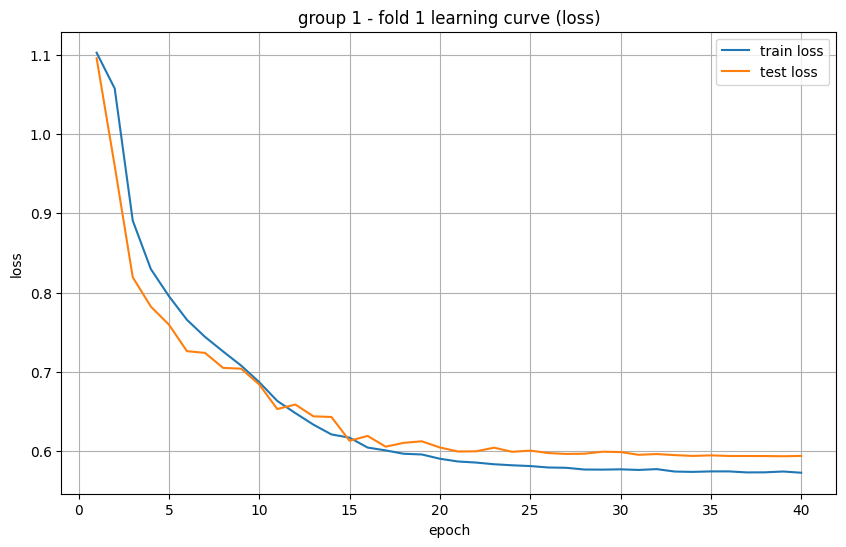

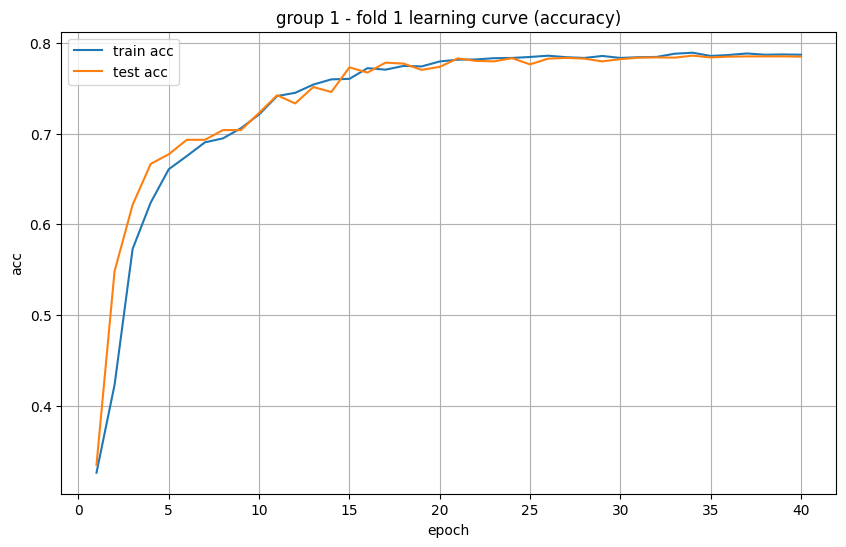

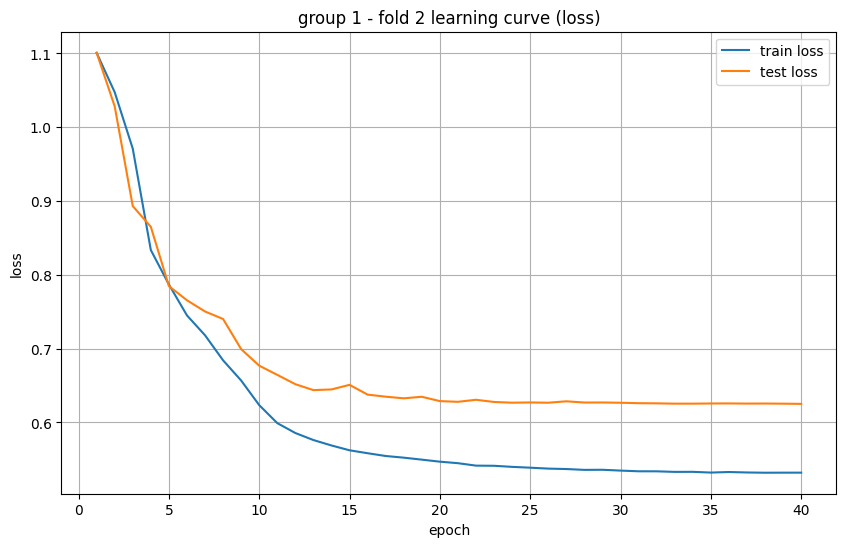

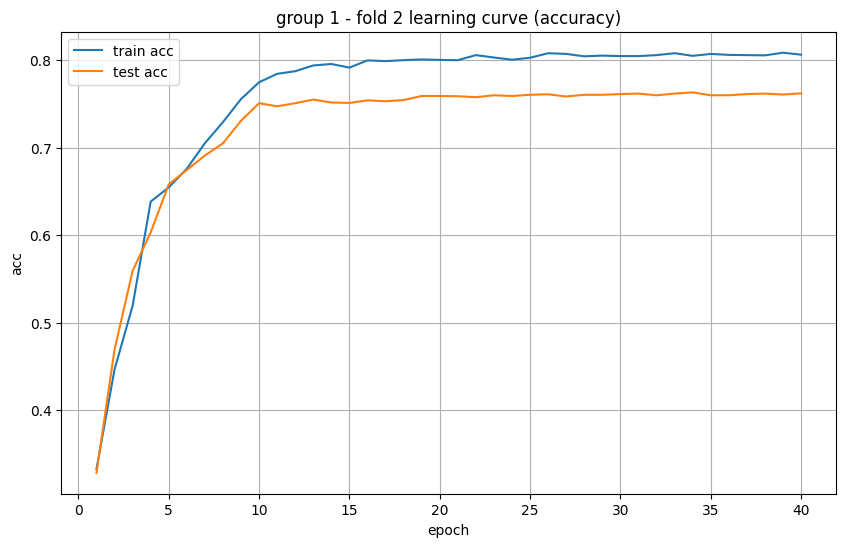

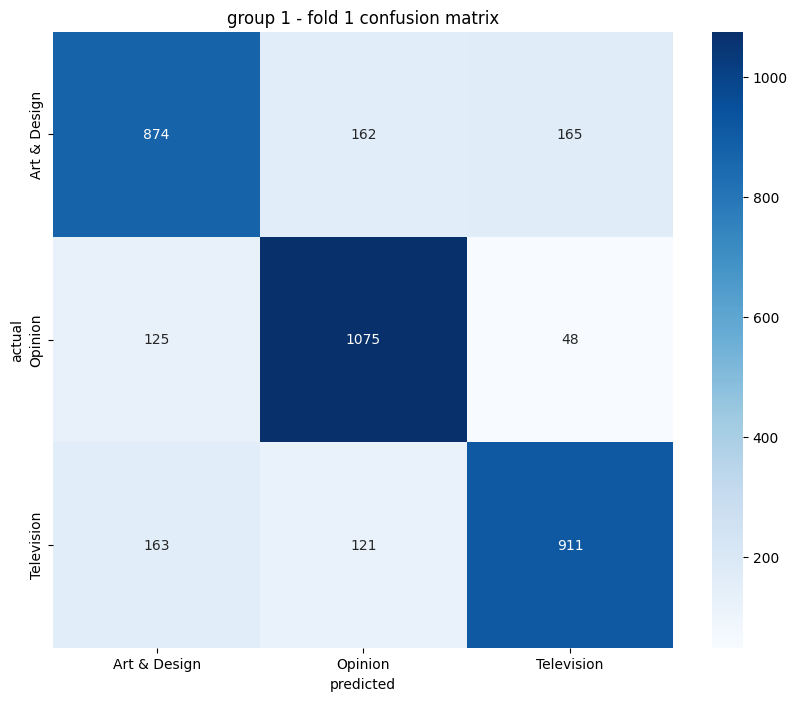

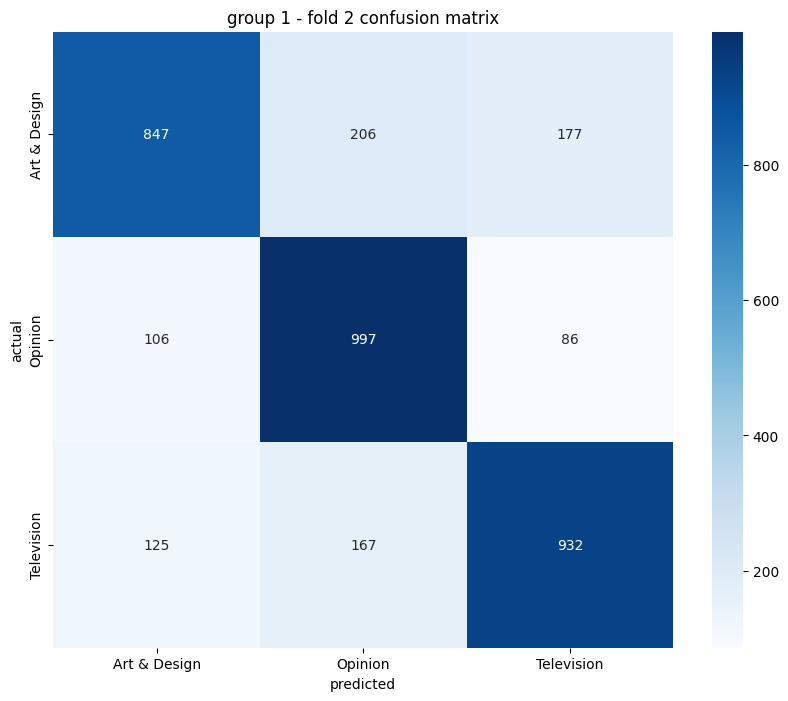


group 2 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1009, train acc: 0.3355
                               test loss: 1.1002, test acc: 0.3350
    epoch 5/40: train loss: 0.8970, train acc: 0.5852
                               test loss: 0.8680, test acc: 0.6073
    epoch 10/40: train loss: 0.8133, train acc: 0.6490
                               test loss: 0.8361, test acc: 0.6288
    epoch 15/40: train loss: 0.7868, train acc: 0.6617
                               test loss: 0.8210, test acc: 0.6448
    epoch 20/40: train loss: 0.7762, train acc: 0.6755
                               test loss: 0.8142, test acc: 0.6504
    epoch 25/40: train loss: 0.7720, train acc: 0.6774
                               test loss: 0.8128, test acc: 0.6484
    epoch 30/40: train loss: 0.7691, train acc: 0.6796
                               test loss: 0.8104, test acc: 0.6520
    epoch 35/40: train loss: 0.7624, train acc: 0.6805
                               test loss: 0.8105, test a

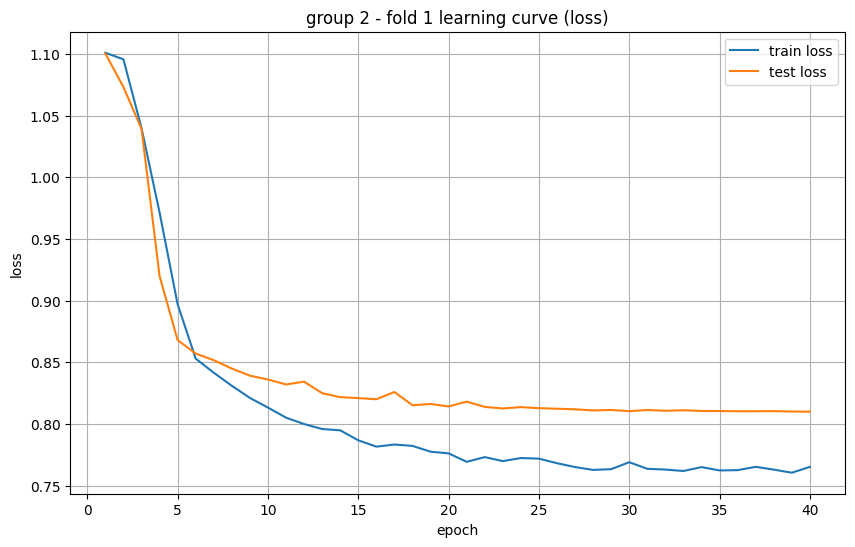

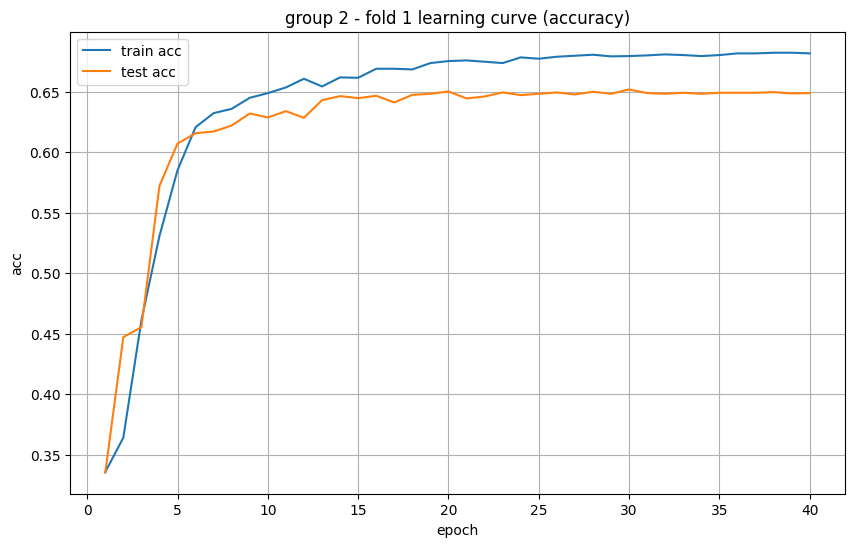

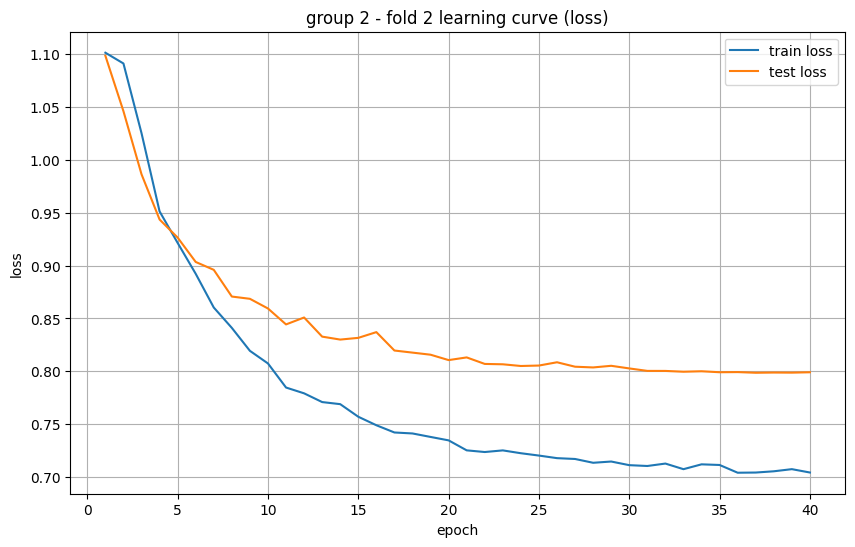

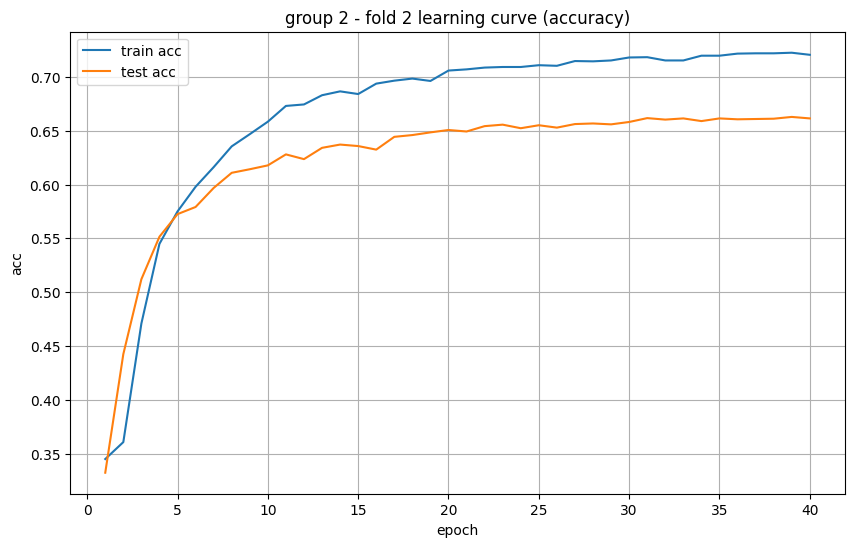

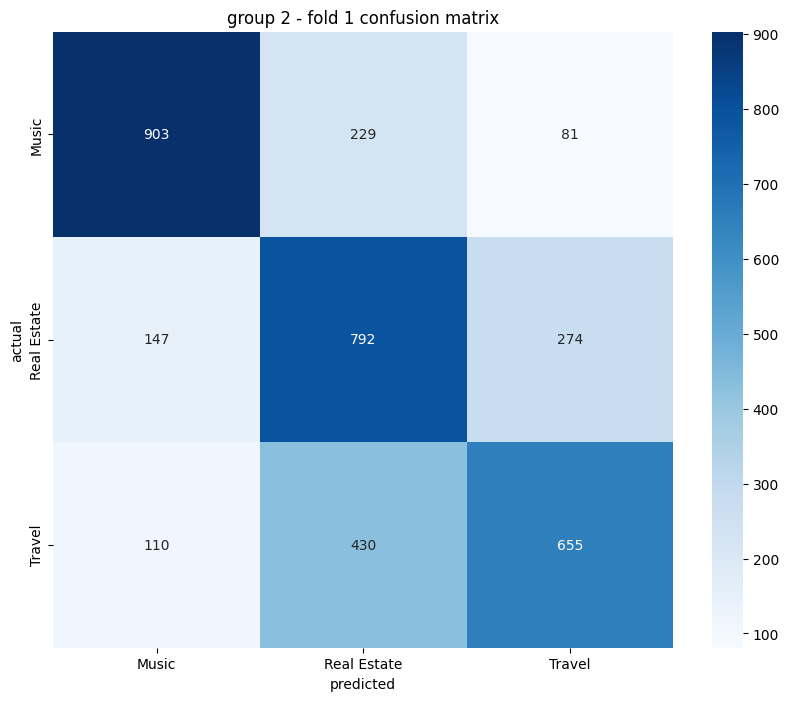

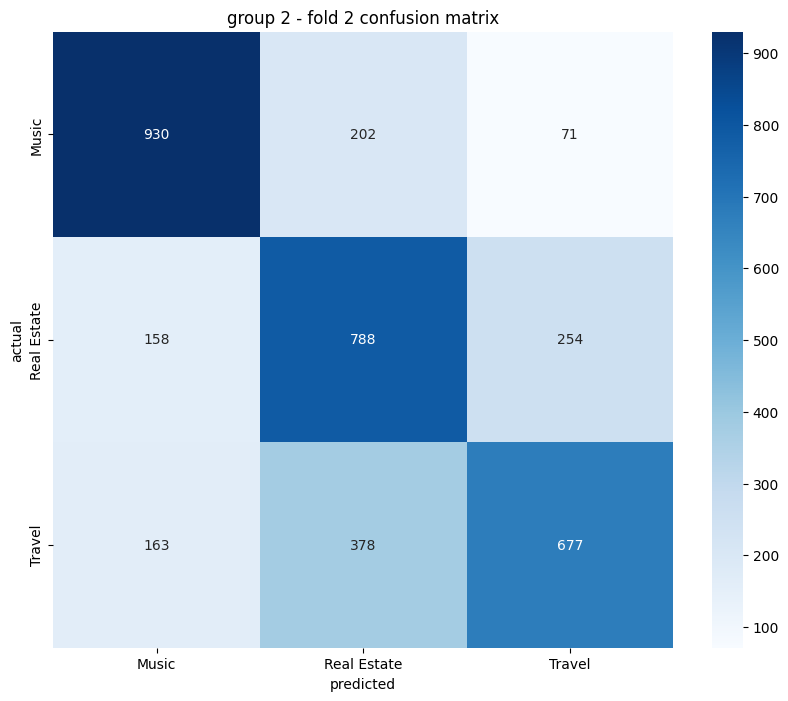


group 3 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.0996, train acc: 0.3488
                               test loss: 1.0970, test acc: 0.4772
    epoch 5/40: train loss: 0.9692, train acc: 0.5090
                               test loss: 0.9453, test acc: 0.5320
    epoch 10/40: train loss: 0.6122, train acc: 0.7657
                               test loss: 0.6542, test acc: 0.7380
    epoch 15/40: train loss: 0.5120, train acc: 0.8105
                               test loss: 0.6073, test acc: 0.7604
    epoch 20/40: train loss: 0.4805, train acc: 0.8199
                               test loss: 0.5950, test acc: 0.7660
    epoch 25/40: train loss: 0.4675, train acc: 0.8246
                               test loss: 0.5910, test acc: 0.7687
    epoch 30/40: train loss: 0.4616, train acc: 0.8230
                               test loss: 0.5899, test acc: 0.7687
    epoch 35/40: train loss: 0.4581, train acc: 0.8293
                               test loss: 0.5891, test a

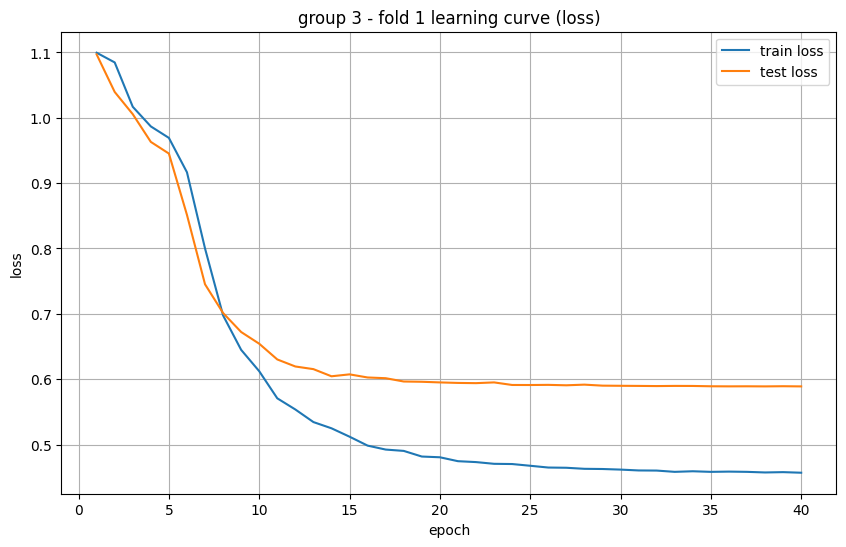

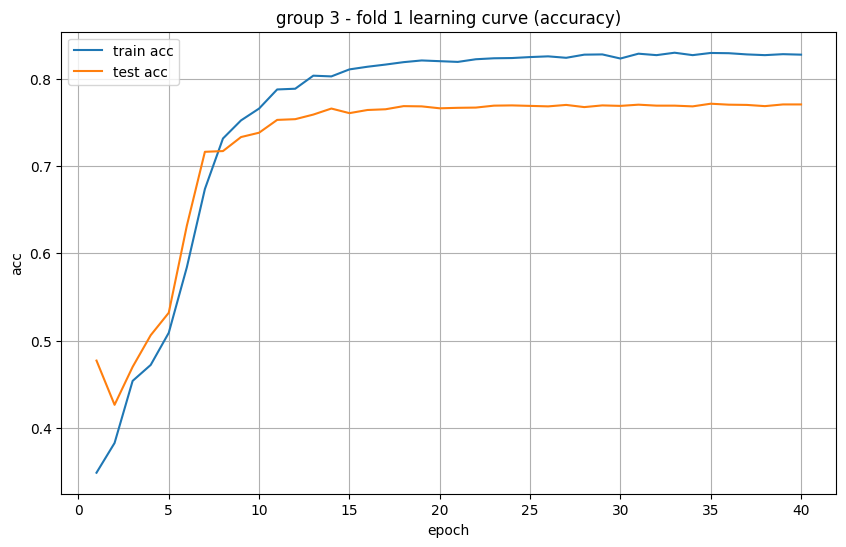

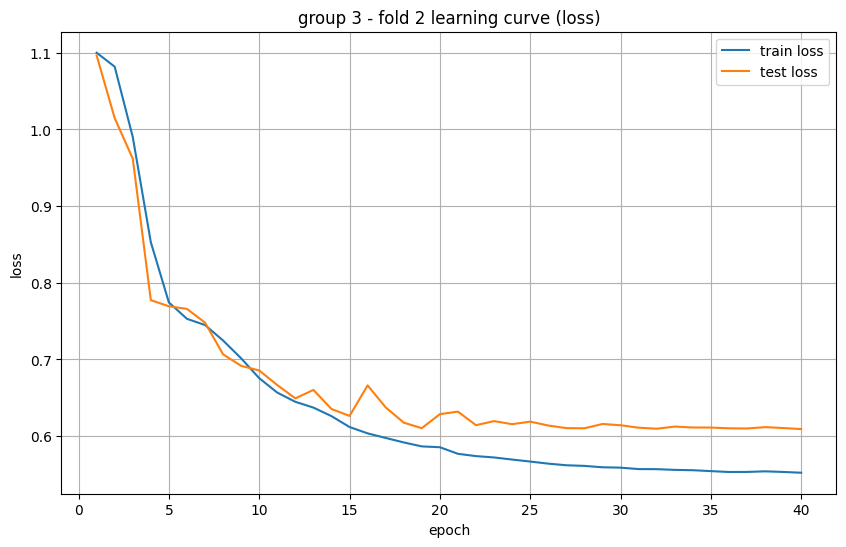

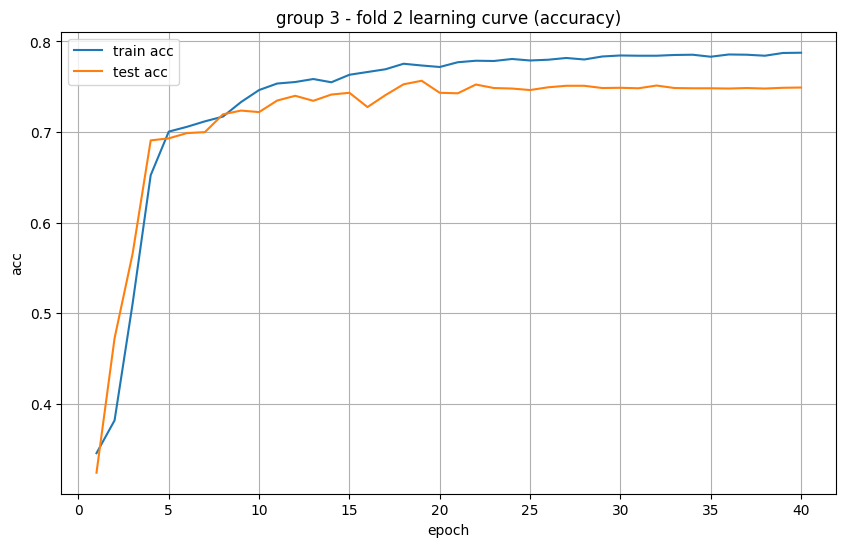

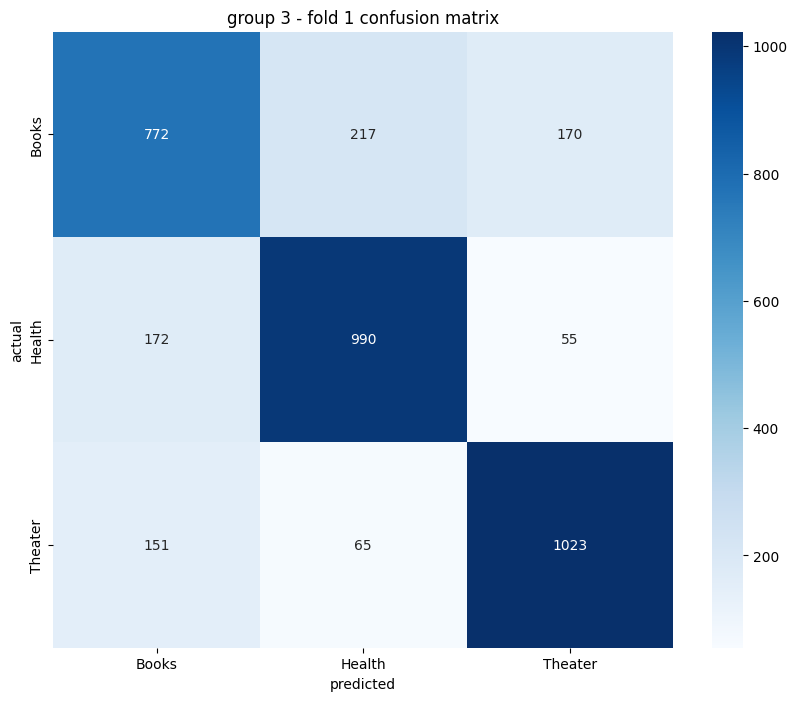

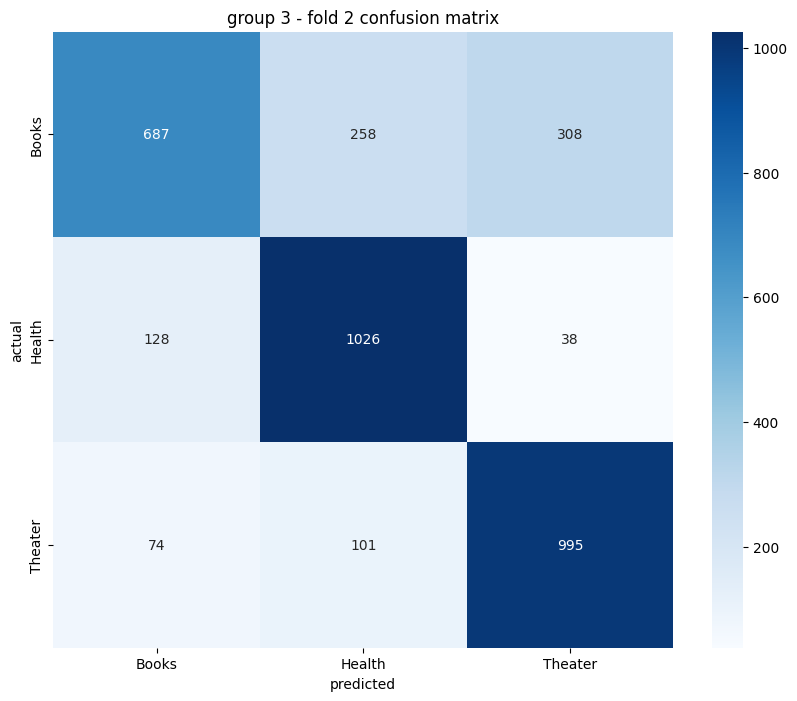


group 4 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1007, train acc: 0.3458
                               test loss: 1.0981, test acc: 0.3223
    epoch 5/40: train loss: 0.9717, train acc: 0.4987
                               test loss: 0.9931, test acc: 0.4766
    epoch 10/40: train loss: 0.7950, train acc: 0.6500
                               test loss: 0.8702, test acc: 0.6070
    epoch 15/40: train loss: 0.7360, train acc: 0.6899
                               test loss: 0.8408, test acc: 0.6340
    epoch 20/40: train loss: 0.7121, train acc: 0.6999
                               test loss: 0.8356, test acc: 0.6370
    epoch 25/40: train loss: 0.7034, train acc: 0.7125
                               test loss: 0.8335, test acc: 0.6426
    epoch 30/40: train loss: 0.7003, train acc: 0.7122
                               test loss: 0.8375, test acc: 0.6440
    epoch 35/40: train loss: 0.6928, train acc: 0.7172
                               test loss: 0.8381, test a

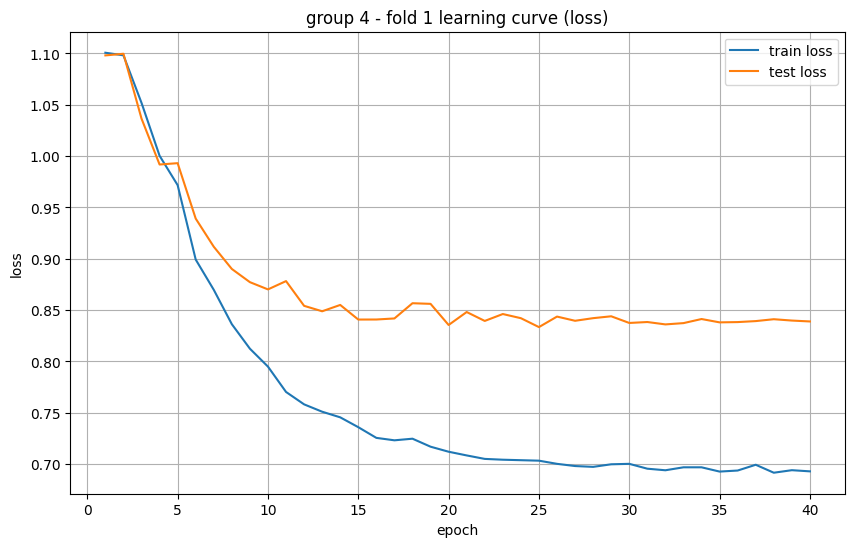

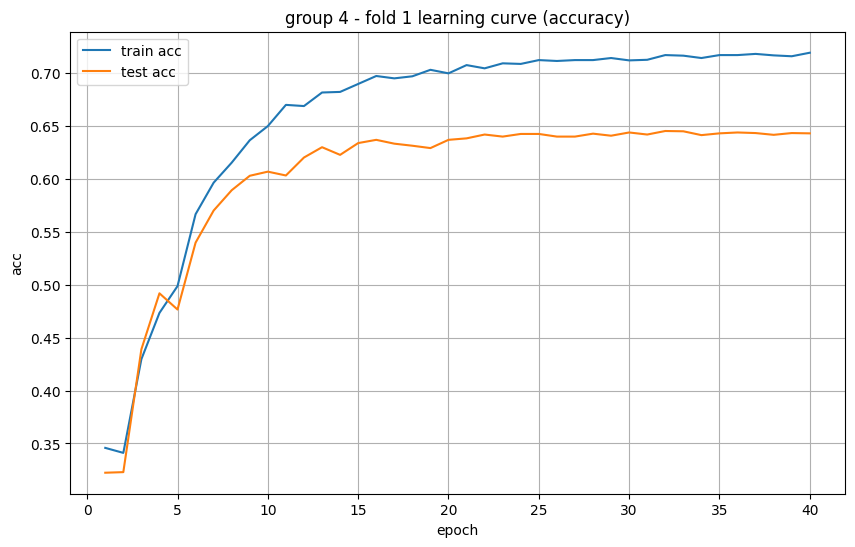

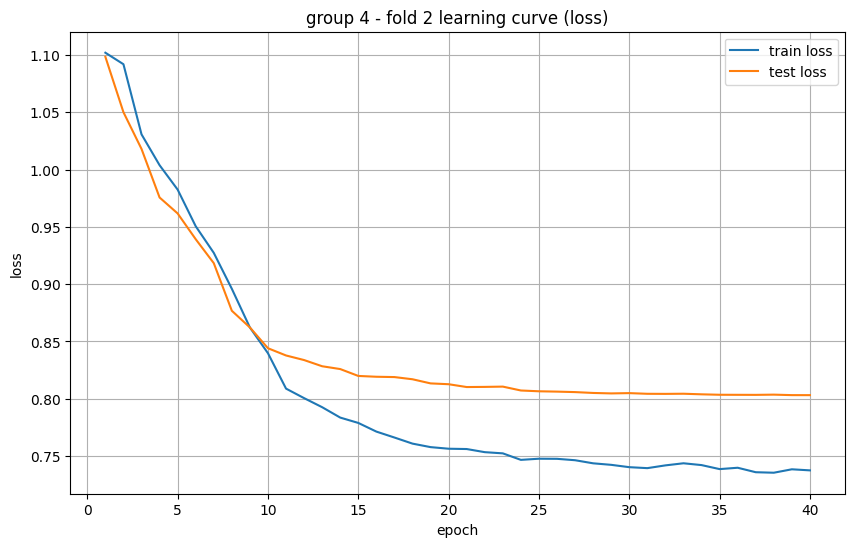

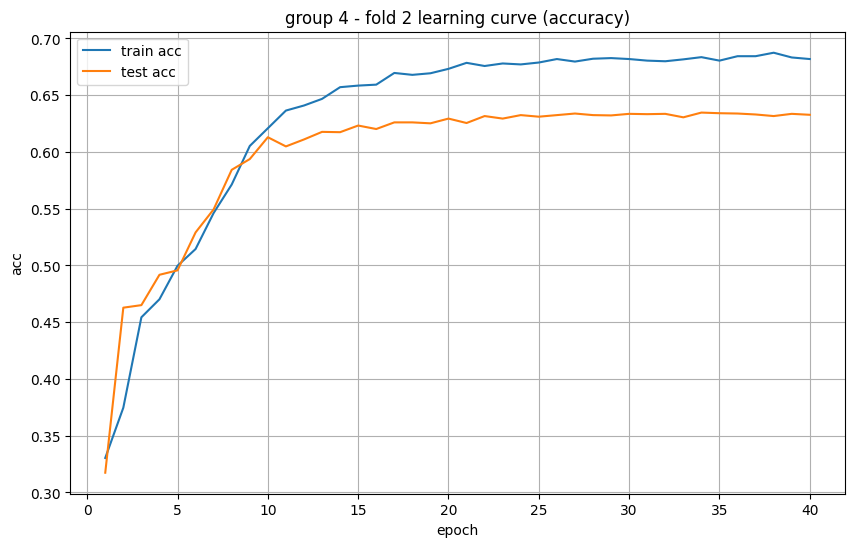

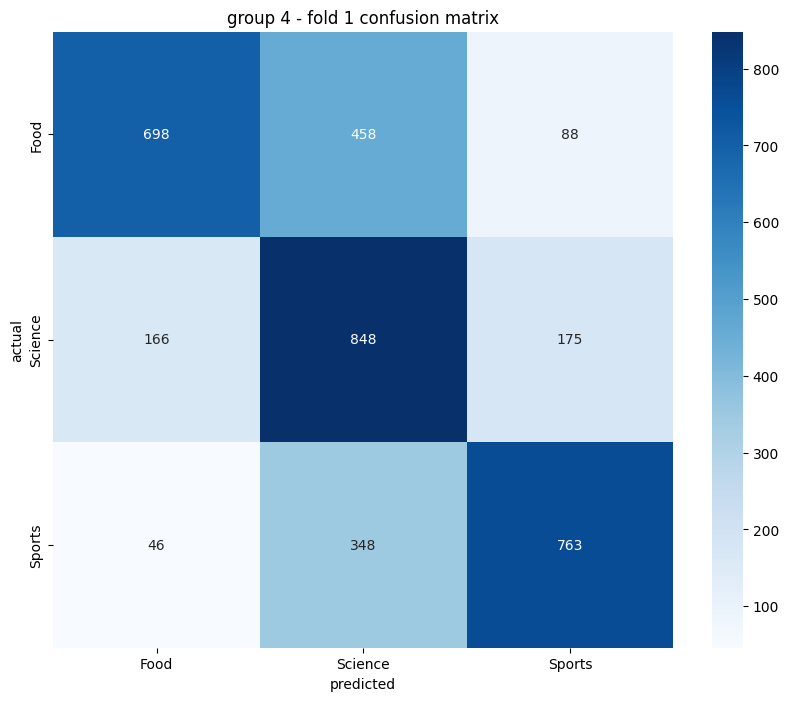

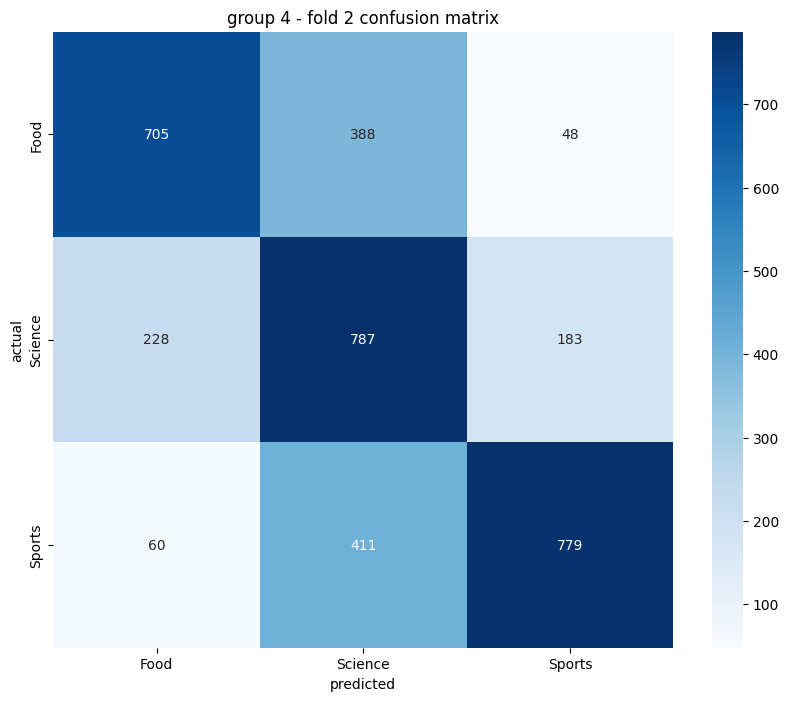


group 5 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.1022, train acc: 0.3326
                               test loss: 1.0983, test acc: 0.3303
    epoch 5/40: train loss: 0.7931, train acc: 0.6669
                               test loss: 0.7657, test acc: 0.6835
    epoch 10/40: train loss: 0.6101, train acc: 0.7786
                               test loss: 0.6482, test acc: 0.7571
    epoch 15/40: train loss: 0.5349, train acc: 0.8035
                               test loss: 0.6073, test acc: 0.7705
    epoch 20/40: train loss: 0.5132, train acc: 0.8169
                               test loss: 0.5916, test acc: 0.7750
    epoch 25/40: train loss: 0.5038, train acc: 0.8200
                               test loss: 0.5865, test acc: 0.7806
    epoch 30/40: train loss: 0.4985, train acc: 0.8233
                               test loss: 0.5866, test acc: 0.7811
    epoch 35/40: train loss: 0.4969, train acc: 0.8217
                               test loss: 0.5855, test a

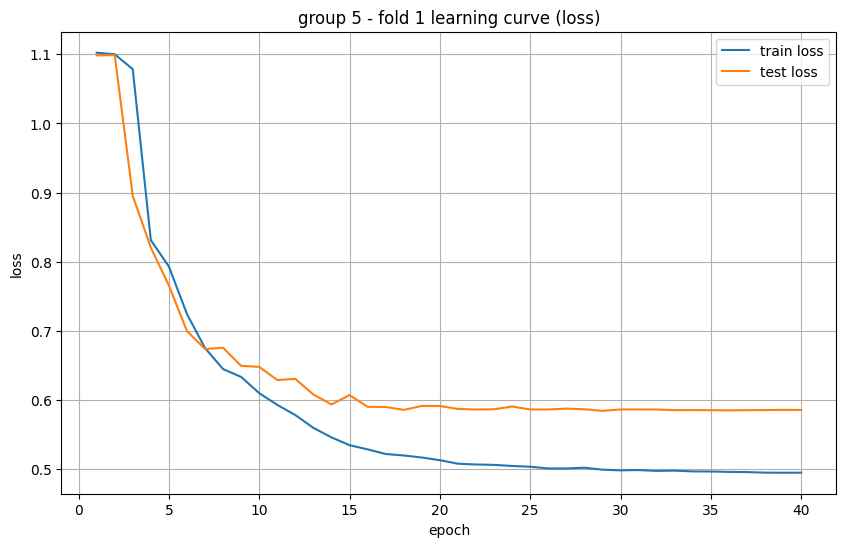

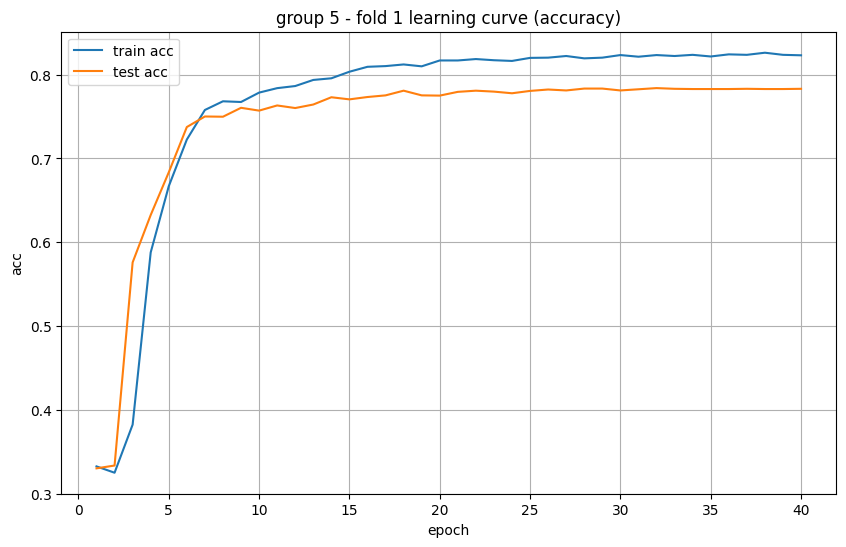

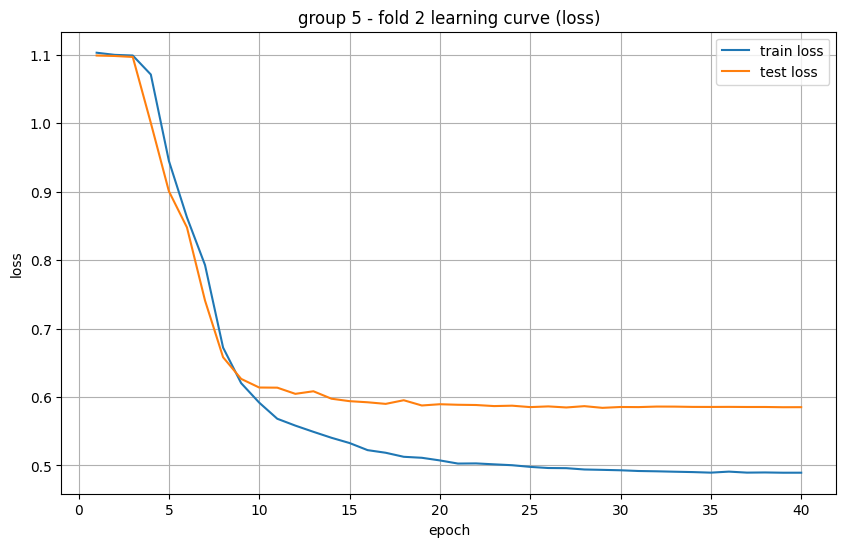

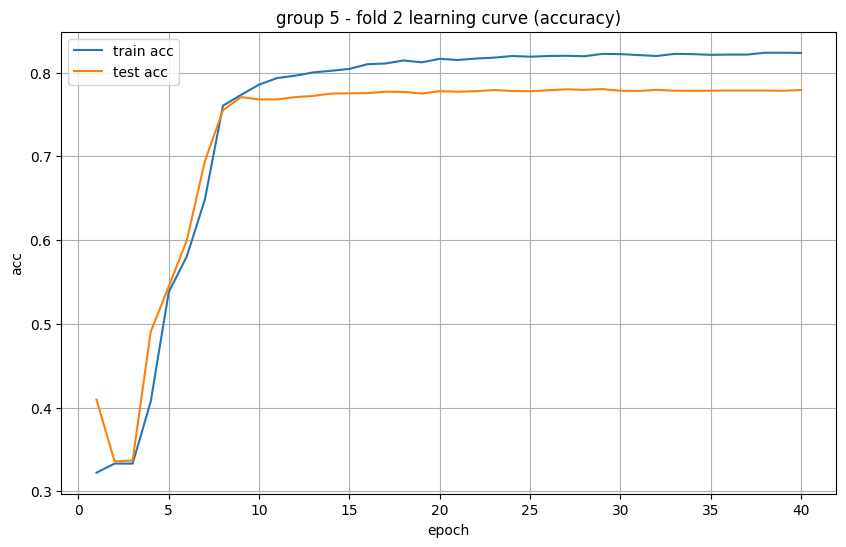

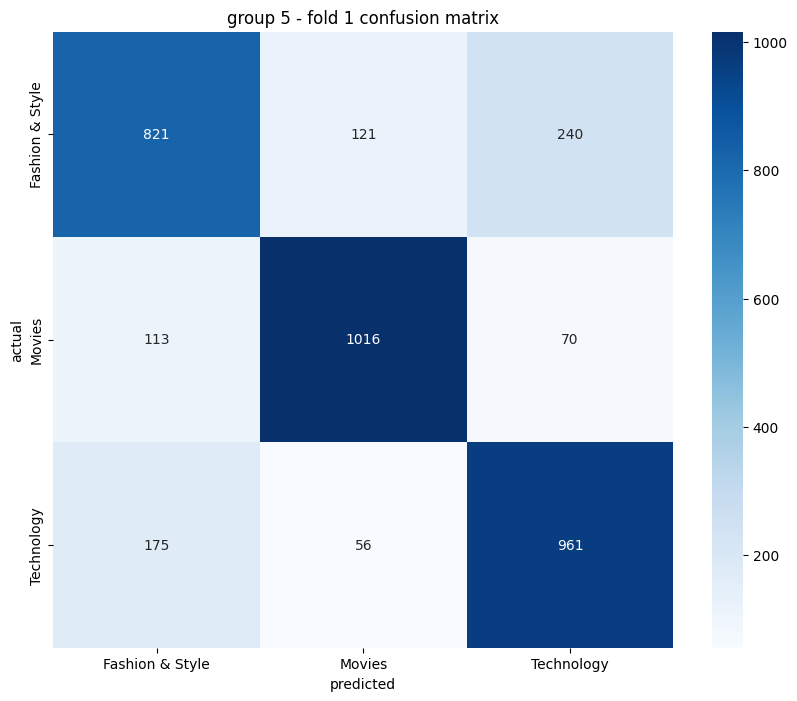

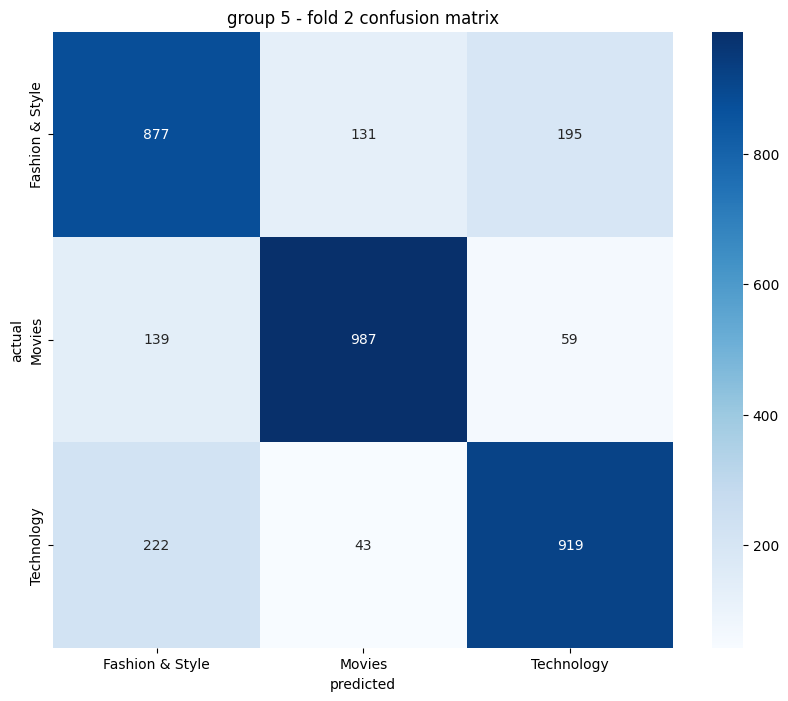


group 6 처리 중...

  fold 1/2 처리 중...
    epoch 1/40: train loss: 1.0994, train acc: 0.3422
                               test loss: 1.0976, test acc: 0.3421
    epoch 5/40: train loss: 0.9677, train acc: 0.5374
                               test loss: 0.9383, test acc: 0.5692
    epoch 10/40: train loss: 0.8921, train acc: 0.5994
                               test loss: 0.9049, test acc: 0.5803
    epoch 15/40: train loss: 0.8718, train acc: 0.6125
                               test loss: 0.8944, test acc: 0.5873
    epoch 20/40: train loss: 0.8603, train acc: 0.6238
                               test loss: 0.8923, test acc: 0.5931
    epoch 25/40: train loss: 0.8546, train acc: 0.6247
                               test loss: 0.8915, test acc: 0.5934
    epoch 30/40: train loss: 0.8522, train acc: 0.6282
                               test loss: 0.8915, test acc: 0.5966
    epoch 35/40: train loss: 0.8503, train acc: 0.6273
                               test loss: 0.8909, test a

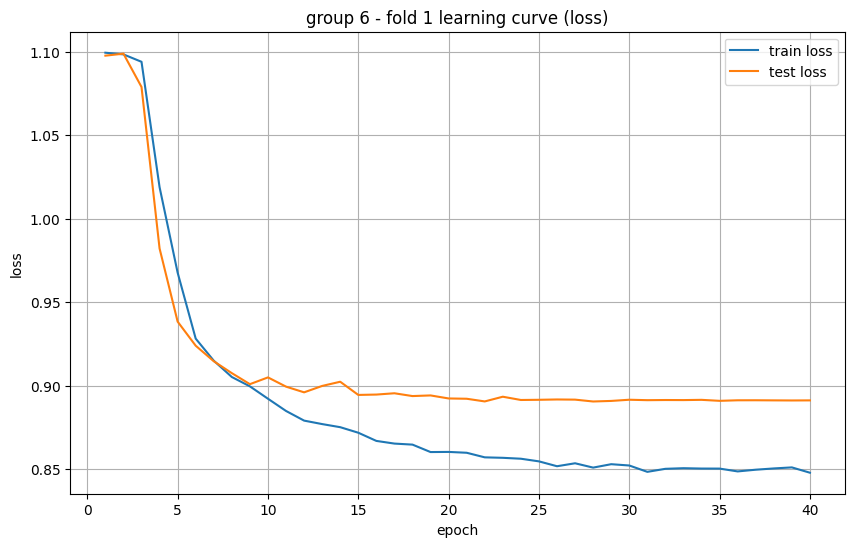

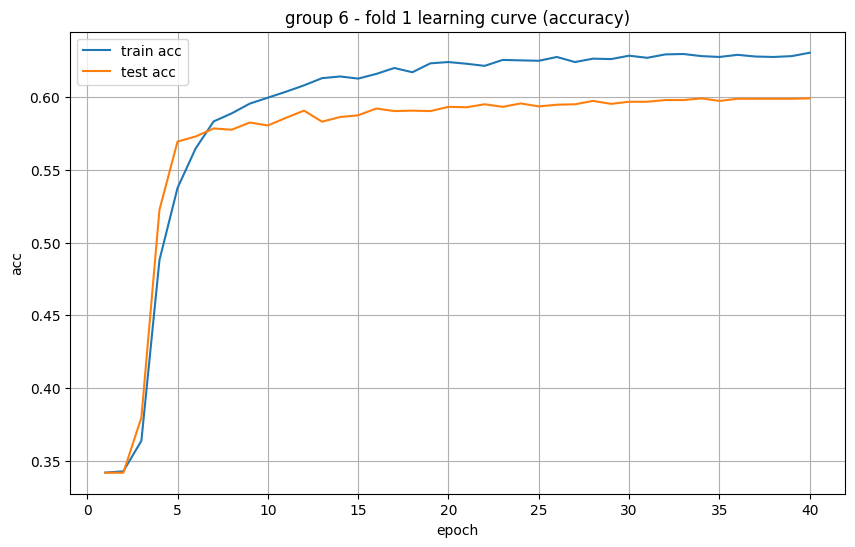

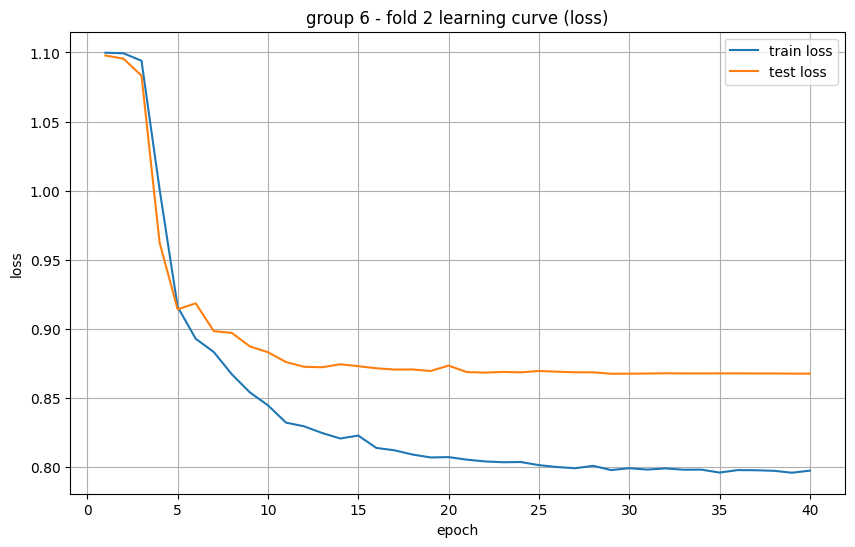

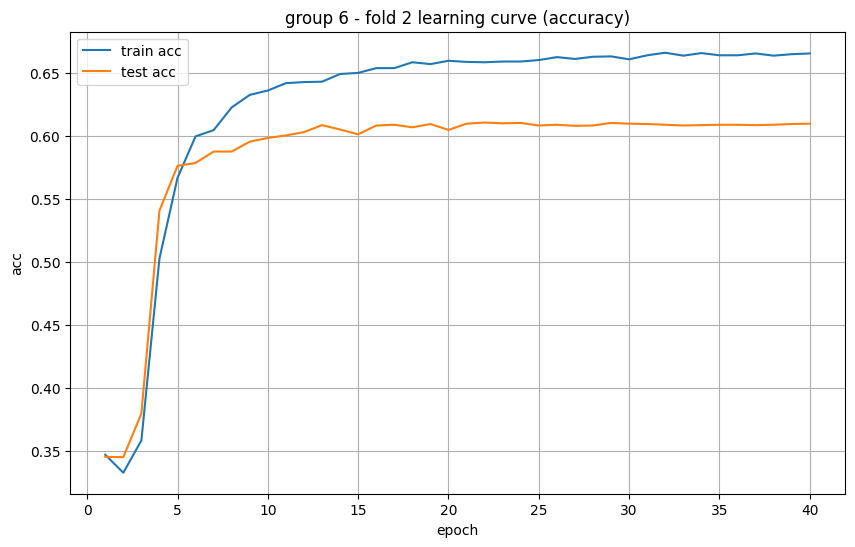

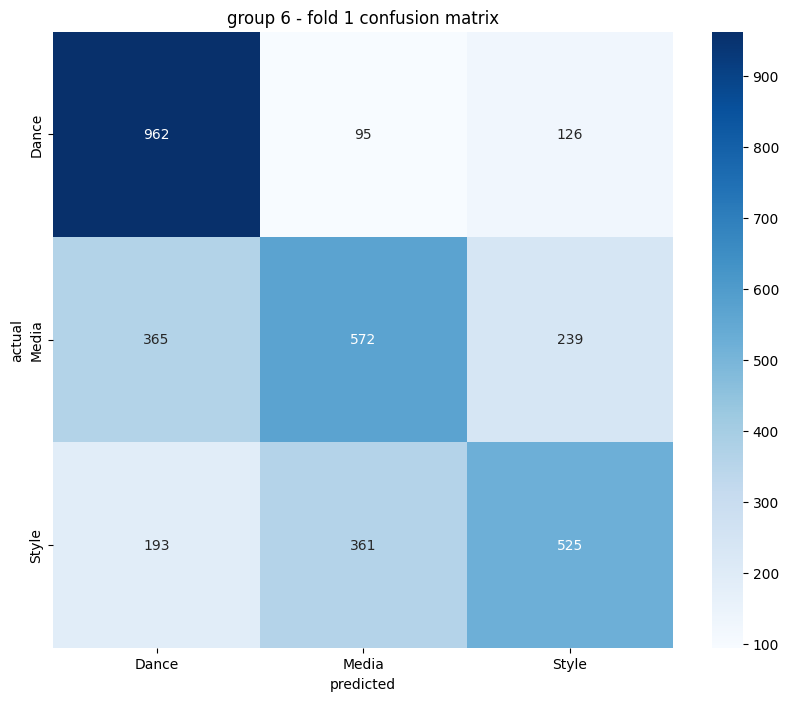

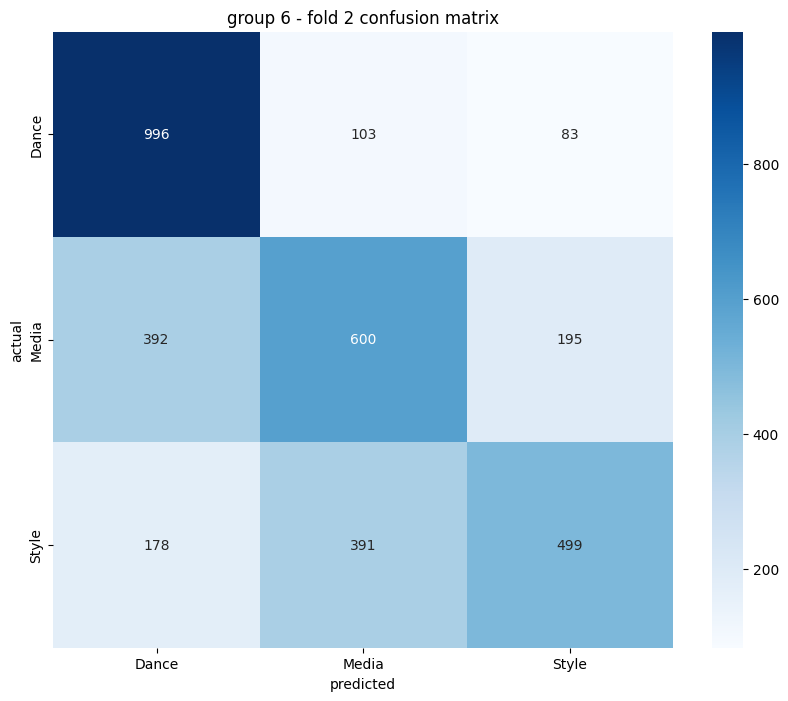


=== 모든 그룹의 요약 결과 ===

그룹 1 - 평균 테스트 정확도: 0.7734
  폴드 1: 테스트 정확도 = 0.7849
  폴드 2: 테스트 정확도 = 0.7620

그룹 2 - 평균 테스트 정확도: 0.6552
  폴드 1: 테스트 정확도 = 0.6490
  폴드 2: 테스트 정확도 = 0.6614

그룹 3 - 평균 테스트 정확도: 0.7598
  폴드 1: 테스트 정확도 = 0.7704
  폴드 2: 테스트 정확도 = 0.7491

그룹 4 - 평균 테스트 정확도: 0.6380
  폴드 1: 테스트 정확도 = 0.6432
  폴드 2: 테스트 정확도 = 0.6328

그룹 5 - 평균 테스트 정확도: 0.7811
  폴드 1: 테스트 정확도 = 0.7831
  폴드 2: 테스트 정확도 = 0.7791

그룹 6 - 평균 테스트 정확도: 0.6042
  폴드 1: 테스트 정확도 = 0.5989
  폴드 2: 테스트 정확도 = 0.6095


In [11]:
EPOCHS = 40
BATCH_SIZE = 32
K_FOLDS = 2
results = []
VOCAB_SIZE = tokenizer.vocab_size
EMBED_DIM = 128
LATENT_DIM = 64
LATENT_SIZE = 64  # Latent의 수
NUM_BLOCKS = 4    # PerceiverBlock의 수
LR = 1e-4

all_learning_curves = []
best_models = {} 

for idx, group_file in enumerate(output_paths, start=1):
    print(f"\ngroup {idx} 처리 중...")

    df = pd.read_csv(group_file)
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    num_classes = len(label_encoder.classes_)

    input_ids, attention_masks = tokenize_data(df, tokenizer=tokenizer, MAX_LENGTH=MAX_LENGTH)
    labels = torch.tensor(df['Label'].values)

    dataset = CustomDataset(input_ids, attention_masks, labels)

    kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

    fold_results = []
    fold_learning_curves = []
    best_fold_acc = 0.0
    best_model = None
    best_valid_loader = None

    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset), start=1):
        print(f"\n  fold {fold}/{K_FOLDS} 처리 중...")

        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

        perceiver = Perceiver(
            input_dim=EMBED_DIM,
            latent_dim=LATENT_DIM,
            latent_size=LATENT_SIZE,
            num_classes=num_classes,
            num_blocks=NUM_BLOCKS,
            self_attn_layers_per_block=1
        )

        model = CombinedModel(
            vocab_size=VOCAB_SIZE,
            embed_dim=EMBED_DIM,
            perceiver_model=perceiver
        )
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LR)  
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            scheduler.step()

            current_lr = LR
            current_lr = scheduler.get_last_lr()[0]
            if (epoch + 1) % 5 == 0 or epoch == 0:
                print(f'    epoch {epoch+1}/{EPOCHS}: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}')
                print(f'                               test loss: {test_loss:.4f}, test acc: {test_acc:.4f}')
        if test_acc > best_fold_acc:
            best_fold_acc = test_acc
            best_model = model
            best_valid_loader = test_loader

        fold_learning_curves.append({
            "Fold": fold,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids_batch = batch['input_ids'].to(device)
                attention_mask_batch = batch['attention_mask'].to(device)  
                labels_batch = batch['labels'].to(device)

                outputs = model(input_ids_batch)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels_batch.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)
        fold_results.append({
            "Fold": fold,
            "Test Accuracy": test_acc,
            "Confusion Matrix": cm,
            "Classification Report": report
        })
    

    # 모델 및 데이터로더 저장장
    model_save_path = f"{model_path}/text_model_{idx}.pkl"
    torch.save(best_model, model_save_path)
    print(f"Group {idx} 최고 모델 저장 완료: {model_save_path}")

    # val_loader_save_path = f"{loader_path}/text_val_loader_{idx}.pkl"
    # with open(val_loader_save_path, 'wb') as f:
    #     pickle.dump(best_valid_loader, f) 
    # print(f"Group {idx} 최고 valid loader 저장 완료: {val_loader_save_path}")
    
    
    # 결과 Analysis
    avg_accuracy = np.mean([fr["Test Accuracy"] for fr in fold_results])
    results.append({
        "Group": idx,
        "Average Test Accuracy": avg_accuracy,
        "Fold Results": fold_results
    })

    all_learning_curves.append({
        "Group": idx,
        "Fold Learning Curves": fold_learning_curves
    })

  
    print(f"\n그룹 {idx}의 {K_FOLDS} 폴드 평균 테스트 정확도: {avg_accuracy:.4f}")

    for fold_result in fold_results:
        print(f"\n  폴드 {fold_result['Fold']} 결과:")
        print(f"    테스트 정확도: {fold_result['Test Accuracy']:.4f}")
        print(pd.DataFrame(fold_result['Classification Report']).transpose())

    for curve in fold_learning_curves:
        fold_idx = curve["Fold"]

        
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="train loss")
        plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="test loss")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (loss)")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(True)
        plt.show()

   
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="train acc")
        plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="test acc")
        plt.title(f"group {idx} - fold {fold_idx} learning curve (accuracy)")
        plt.xlabel("epoch")
        plt.ylabel("acc")
        plt.legend()
        plt.grid(True)
        plt.show()

    
    for fold_result in fold_results:
        fold_idx = fold_result["Fold"]
        cm = fold_result["Confusion Matrix"]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=label_encoder.classes_, 
                    yticklabels=label_encoder.classes_)
        plt.title(f"group {idx} - fold {fold_idx} confusion matrix")
        plt.xlabel("predicted")
        plt.ylabel("actual")
        plt.show()

print("\n=== 모든 그룹의 요약 결과 ===")
for result in results:
    group_idx = result["Group"]
    avg_acc = result["Average Test Accuracy"]
    print(f"\n그룹 {group_idx} - 평균 테스트 정확도: {avg_acc:.4f}")
    for fold_result in result["Fold Results"]:
        fold_idx = fold_result["Fold"]
        fold_acc = fold_result["Test Accuracy"]
        print(f"  폴드 {fold_idx}: 테스트 정확도 = {fold_acc:.4f}")

In [12]:
import pickle

file_path = "/home/youlee/perceiver/perceiver/loader/text_val_loader_1.pkl"

with open(file_path, "rb") as file:
    data = pickle.load(file)

type_of_data = type(data)
if hasattr(data, 'shape'):
    data_shape = data.shape
else:
    try:
        data_shape = (len(data), len(data[0]))
    except Exception as e:
        data_shape = f"Cannot determine shape: {e}"

type_of_data, data_shape


(torch.utils.data.dataloader.DataLoader,
 "Cannot determine shape: 'DataLoader' object is not subscriptable")

In [13]:
for batch in data:
  
    if isinstance(batch, dict):
        print({key: value.shape for key, value in batch.items()})

    elif isinstance(batch, tuple):
        print(f"Inputs shape: {batch[0].shape}, Labels shape: {batch[1].shape}")
    else:
        print(f"Unknown batch format: {type(batch)}")
    break  

{'input_ids': torch.Size([32, 128]), 'attention_mask': torch.Size([32, 128]), 'labels': torch.Size([32])}
